# Deploying GenAI In Production With NVIDIA & MLRun

In this demo we will learn about **NVIDIA NIMs** and how to use them with a production first mindset using **MLRun**. We will see how to deploy and operationalize the NIM with MLRun's model monitoring and finally, create a **multi-agent banking chatbot** using MLRun's GenAI Factory.

## Table of Content

1. [How to Deploy a NIM with MLRun?](#section_1)
2. [How to Use a NIM?](#section_2)
3. [How to Oprationalize a NIM using MLRun?](#section_3)
4. [MLRun's GenAI Factory](#section_4)

## Prerequisites

* **Previous Knowledge** - The demo is leaning on the following MLRun and LLM usage knoweledge:
  * MLRun basic components ([projects](https://docs.mlrun.org/en/stable/projects/project.html) and [functions](https://docs.mlrun.org/en/stable/runtimes/functions.html))
  * [LangChain](https://python.langchain.com/docs/tutorials/llm_chain/) basics (for the exmaple)
* **Python packages** - The following python packages are required. You can install them at the next cell:
  * `mlrun` - to orchestrate and operationlize the demo.
  * `langchain_nvidia_ai_endpoints` and `langchain-openai` - to write the exmaple and use the NIM.

In [ ]:
!pip install mlrun langchain_nvidia_ai_endpoints langchain-openai 

In [ ]:
!pip install mlrun==1.7.0-rc58

* **MLRun project** - We'll create an MLRun project for the demo:

In [1]:
import mlrun

project = mlrun.get_or_create_project(name="mlrun-nvidia-demo")

> 2024-10-29 09:46:09,148 [info] Loading project from path: {"path":"./","project_name":"mlrun-nvidia-demo","user_project":false}
> 2024-10-29 09:46:09,169 [warning] Project name mismatch, mlrun-nim-demo != mlrun-nvidia-demo, project is loaded from mlrun-nim-demo project yaml. To prevent/allow this, you can take one of the following actions:
1. Set the `allow_cross_project=True` when loading the project.
2. Delete the existing project yaml, or ensure its name is equal to mlrun-nvidia-demo.
3. Use different project context dir.


Project name='mlrun-nvidia-demo' is different than specified on the context's project yaml. This behavior is deprecated and will not be supported from version 1.9.0.


> 2024-10-29 09:46:23,735 [info] Project loaded successfully: {"path":"./","project_name":"mlrun-nvidia-demo","stored_in_db":true}


* **Credentials**:
  * NVIDIA NGC API Key - To use the NIM.
  * OpenAI Key - For the monitoring (LLM as a Judge).

In [4]:
import os
from src.nim_application import NIMApplication
from src.langchain_mlrun_llm import MLRun
from mlrun.features import Feature  # To log the model with inputs and outputs information

# Deploy all the real-time monitoring functions:
project.set_model_monitoring_credentials(
    os.environ["V3IO_ACCESS_KEY"],
    "v3io",
    "v3io",
    "v3io",
)

NGC_API_KEY = ""
OPENAI_BASE_URL = ""
OPENAI_API_KEY = ""

project.set_secrets(
    secrets={
        "OPENAI_BASE_URL": OPENAI_BASE_URL,
        "OPENAI_API_KEY": OPENAI_API_KEY,
    }
)

project.log_model(
    "nim-gateway-model",
    model_file="data/my_dummy_model.pkl",
    inputs=[Feature(value_type="str", name="question")],
    outputs=[Feature(value_type="str", name="answer")],
)

___
<a id="section_1"></a>
## 1. How to Deploy a NIM with MLRun?

In this section we will learn about NVIDIA NIM and how to use MLRun's application runtime to deploy it.

### 1.1. What is a NIM?

NVIDIA NIM™, part of NVIDIA AI Enterprise, provides containers to self-host GPU-accelerated inferencing microservices for pretrained and customized AI models across clouds, data centers, and workstations. NIM microservices expose industry-standard APIs for simple integration into AI applications, development frameworks, and workflows. Built on pre-optimized inference engines from NVIDIA and the community, including NVIDIA® TensorRT™ and TensorRT-LLM, NIM microservices automatically optimize response latency and throughput for each combination of foundation model and GPU system detected at runtime. NIM containers also provide standard observability data feeds and built-in support for autoscaling on Kubernetes on GPUs.

### 1.2. MLRUN's NIM Application

First, choose the NIM you wish to use. You can see the available NIMs [here](https://docs.nvidia.com/nim/large-language-models/latest/models.html). In this demo, we will use a `meta/llama3-8b-instruct` NIM. 

In [5]:
MODEL_NAME = "meta/llama3-8b-instruct"

To deploy a NIM using MLRun, we will use MLRun's `NIMApplication`. NIM Application is a wrapper for creating an application runtime to deploy a NIM as a serverless function using nuclio. The application runtime deploys a container image (the NIM image) that is exposed on a specific port. The runtime is based on top of Nuclio, and adds the application as a side-car to a Nuclio function pod while the actual function is a reverse proxy to that application. To learn more about application runtimes, go to the [documentation](https://docs.mlrun.org/en/latest/runtimes/application.html#application).

In [6]:
nim_application = NIMApplication(
    name="my-nim-5",
    model_name=MODEL_NAME,
    ngc_api_key=NGC_API_KEY,
)

### 1.3. Deploy and Test

Using the application's `deploy` and `invoke` methods, you can easily deploy and use the NIM.

In [7]:
nim_application.deploy(force_redeploy=False)

> 2024-10-29 09:46:54,013 [error] Failed to execute command 'kubectl delete secret mlrun-nvidia-demo-my-nim-5-nim-creds': Error from server (Forbidden): secrets "mlrun-nvidia-demo-my-nim-5-nim-creds" is forbidden: User "system:serviceaccount:default-tenant:jupyter-guy-job-executor" cannot delete resource "secrets" in API group "" in the namespace "default-tenant"
> 2024-10-29 09:46:54,208 [error] Failed to execute command 'kubectl delete secret mlrun-nvidia-demo-my-nim-5-ngc-api-key': Error from server (Forbidden): secrets "mlrun-nvidia-demo-my-nim-5-ngc-api-key" is forbidden: User "system:serviceaccount:default-tenant:jupyter-guy-job-executor" cannot delete resource "secrets" in API group "" in the namespace "default-tenant"
> 2024-10-29 09:46:54,304 [info] Starting remote function deploy
2024-10-29 09:46:54  (info) Deploying function
2024-10-29 09:46:54  (info) Building
2024-10-29 09:46:54  (info) Staging files and preparing base images
2024-10-29 09:46:54  (info) Building processor 

In [8]:
nim_application.invoke(
    messages="What is the capital of Great Britain?", 
    max_tokens=128
)

<Response [502]>

___
<a id="section_2"></a>
## 2. How to Use a NIM?

Besides of invoking the `NIMApplication` instance, we wish to use the NIM in a specific use case. Using the known framework [LangChain](https://www.langchain.com/) - a framework to build AI logic with LLMs by chaining interoperable components.

### 2.1. Intent Classification Example

Our multi-agent chatbot is constructed of 3 agents:
* Loan agent - answer all loan related questions and related company policies
* Investment agent - answer all investment related questions and related company policies
* General agent - general conversations and customer service

We need to build a classifier to choose to which agent to send the user request. This is called an intent classifier. We will show a simple exmaple of it using LangChain and NVIDIA's integration to it:

In [9]:
classifier_system_prompt = """
You are a helpful AI classifier. Given a request, classify the request to the most relevant category: [loans, investments, other].
Please answer in only one word.

For exmaple:
* human: What is a mortgage? - AI: loans
* human: What stock should I buy? - AI: investments
* human: How far is the moon? - AI: other
* human: Hi - AI: other
"""

In [10]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_nvidia_ai_endpoints.llm import NVIDIA

nim_llm = NVIDIA(
    base_url=f"https://{nim_application.get_url()}",
    model=MODEL_NAME,
    max_tokens=1,
)
classifier_prompt_template = ChatPromptTemplate(
    [
        ("system", classifier_system_prompt),
        ("human", "The request: {request} - AI: "),
    ]
)
classifier_chain = classifier_prompt_template | nim_llm

### 2.2. Test

We can now test out our NIM as part of a legitimate chatbot use case:

> Note: Depends on the NIM selected, the prompt may need to adapt to it. In addition, the asnwers may need some post-processing to remove redundant tokens.

In [11]:
classifier_chain.invoke(
    {
        "request": "can I please have a loan for 5 milion dollars",
    },
)

Exception: [502] Bad Gateway
{'_content': b'', '_content_consumed': True, '_next': None, 'status_code': 502, 'headers': {'Date': 'Tue, 29 Oct 2024 09:49:02 GMT', 'Content-Length': '0', 'Connection': 'keep-alive', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains'}, 'raw': <urllib3.response.HTTPResponse object at 0x7fe6301bd7f0>, 'url': 'https://mlrun-nvidia-demo-my-nim-5-gw.default-tenant.app.llm5.iguazio-cd1.com/v1/completions', 'encoding': None, 'history': [], 'reason': 'Bad Gateway', 'cookies': <RequestsCookieJar[]>, 'elapsed': datetime.timedelta(microseconds=8533), 'request': <PreparedRequest [POST]>, 'connection': <requests.adapters.HTTPAdapter object at 0x7fe6301bd0d0>}

___
<a id="section_3"></a>
## 3. How to Operationalize a NIM using MLRun?

As an orchestrator, MLRun provides MLOps best practices for every layer of a GenAI application, operationalizing data, code and mdoels, including NIMs!

In this section we'll cover how easily **MLRun integrate into an existing code that uses NIMs and enable MLOps features** such as automatic scalling, monitoring and modularity.

### 3.1. Add a LLM Gateway

The MLRun LLM gateway is a great way to enable LLM modularity and monitoring.
* Modularity - The gateway offer a seamless transition between models and vendors, so you can use OpenAI models and NIMs using the same code and API. Changing models is a simple configuration away.
* Monitoring - The gateway allows monitoring in different levels: a specific use case, a specific model, general LLM provider and a higher levels for general usage monitroing such as latency, throughput and memory. All is done by using labels, as simple as that. 

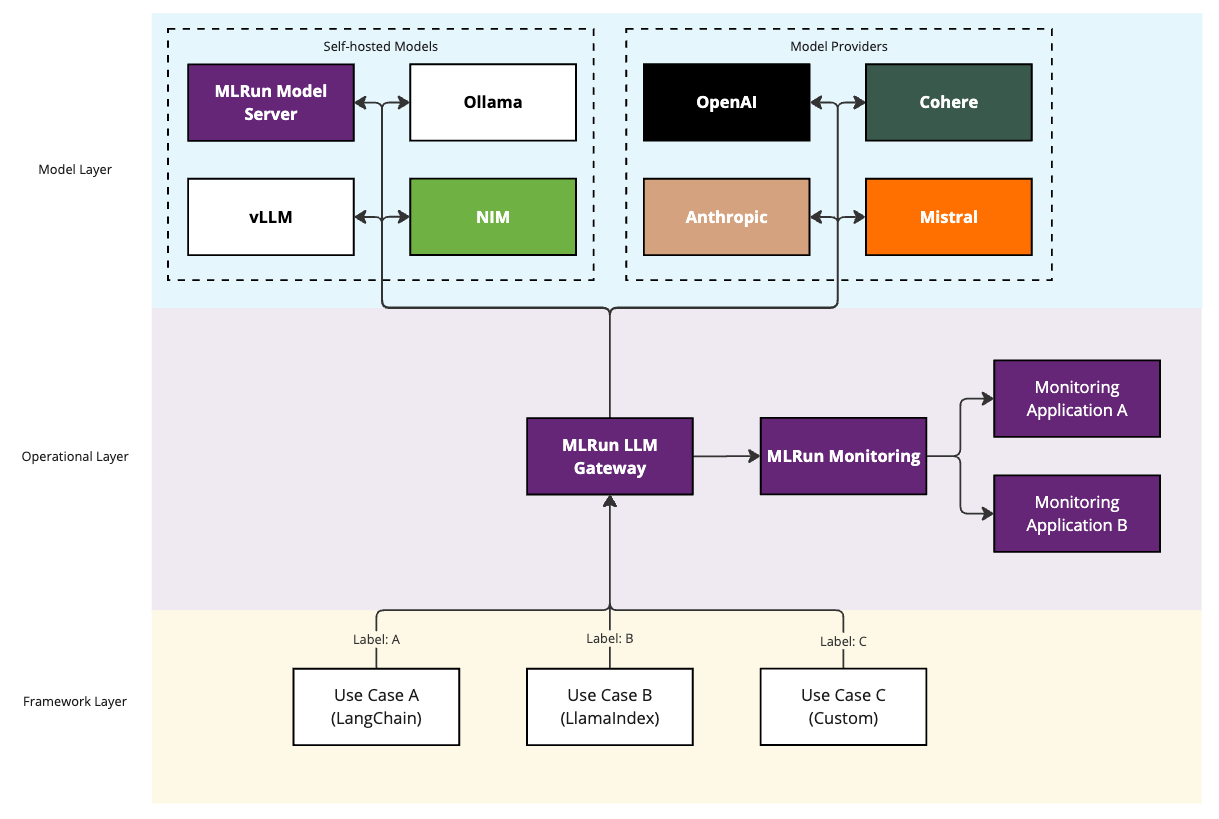

In this demo, we will add a LLM gateway to use the deployed NIM and allow monitoring it later. The gateway is a simple serving function of a `V2ModelServer`. To read more about model servers and serving functions, click [here](https://docs.mlrun.org/en/latest/serving/custom-model-serving-class.html):

In [ ]:
serving_function = project.set_function(
    func="./src/nim_model_server.py",
    name="nim-gateway",
    kind="serving",
    image="mlrun/mlrun",
)
serving_function.add_model(
    "nim_gateway",
    llm="langchain_nvidia_ai_endpoints.llm.NVIDIA",
    class_name="LangChainModelServer",
    init_kwargs={
        "base_url": f"https://{nim_application.get_url()}",
        "model": MODEL_NAME,
        "max_tokens": 1,
    },
    model_path=f"store://models/{project.name}/nim-gateway-model#0:latest",
)

To test it, we will use the `to_mock_server` method:

In [ ]:
mock_server = serving_function.to_mock_server()

In [ ]:
mock_server.test(
    path=f"/v2/models/nim_gateway/infer",
    body={"inputs": ["hello"]},
)

### 3.2. Add a Monitoring Application - LLM as a Judge

The MLRun's monitoring service includes built-in model monitoring and reporting capabilities. It is running **monitoring applications** on recorded data that let you get analysis of:
* Continuous Assessment
* Model performance
* Data drift
* Concept drift
* Operational performance
* And more

To learn more about MLRun monitoring and see how you can write your own monitoring applications, click [here](https://docs.mlrun.org/en/latest/concepts/model-monitoring.html) 

In this demo, we'll use MLRun's **LLM as a Judge monitoring application** to monitor our intent classifier use case. First we'll enable model monitoring:

In [ ]:
project.enable_model_monitoring(
    image="mlrun/mlrun",
    base_period=1,  # frequency (in minutes) at which the monitoring applications are triggered
    deploy_histogram_data_drift_app=False,
)

Then, we'll configure the LLM judge:

> To learn more about prompting the judge, follow the [LLM monitoring demo](https://github.com/mlrun/demo-llm-monitor/tree/main).

In [ ]:
classifier_judge_config = {
    "name": "Classifier Judge",
    "definition": """
The Classifier Judge is a metric used to evaluate if a model classify requests from a user into one of 3 classes correctly. 
The classes are [loans, investments, other]
""",
    "rubric": """
Classifier Judge: The details for different scores are as follows:
    - Score 0: Incorrect - The model classified the request incorrectly.
    - Score 1: Correct - The model correctly classified the request.
""",
    "examples": """
Question: What is the process to apply for a mortgage?
    Score 0: Incorrect
    Answer: "other"
    Score 1: Correct
    Answer: "loans"
Question: Hi, how are you today?
    Score 0: Incorrect
    Answer: "investments"
    Score 1: Correct
    Answer: "other"
""",
}

In [ ]:
monitoring_application = project.set_model_monitoring_function(
    func="src/llm_as_a_judge.py",
    application_class="LLMAsAJudgeApplication",
    name="llm-as-a-judge",
    image="gcr.io/iguazio/llm-as-a-judge:1.7.0",
    framework="openai",
    judge_type="single-grading",
    metric_name="classifier_judge",
    model_name="gpt-4",
    prompt_config=classifier_judge_config,
)

Now, we'll deploy the monitoring application and the gateway:

In [ ]:
project.deploy_function(monitoring_application)

In [ ]:
serving_function.set_tracking()
serving_function.deploy()

### 3.3. Intent Classification Example

Now, looking back at our code from before, all we need to do to use the MLRun LLM Gateway is to replace the `NVIDIA` LLM instance with `MLRun` LLM instance:

In [ ]:
mlrun_llm = MLRun(
    mlrun_function=serving_function,
    model_name="nim_gateway",
)
classifier_chain = classifier_prompt_template | mlrun_llm

### 3.4. Test

We'll test the chain on a dataset to compare the groud truth performance with our judge scores the use case that is using the NIM.

In [ ]:
import pandas as pd
import logging
from tqdm.auto import tqdm
import time

logging.disable(logging.CRITICAL)
dataset = pd.read_csv("data/banking-intents.csv")
result = 0

for _, row in tqdm(dataset.iterrows(), total=len(dataset)):
    request = row["prompt"]
    label = row["label"].lower().strip()
    prediction = classifier_chain.invoke(
        {
            "request": request,
        },
    )["choices"][0]["message"]["content"].lower().strip()
    result += label == prediction
    
print(f"Accuracy: {result / len(dataset)}")
logging.disable(logging.NOTSET)
time.sleep(120)
classifier_chain.invoke(
    {
        "request": request,
    },
)

### 3.6. Review Monitoring

Looking at the Grafana screen of our monitoring application we can see our judge would have scored the intent classifeir we had about the same!

___
<a id="section_4"></a>
## 4. MLRun's GenAI Factory

MLRun's GenAI Factory is a flexible and scalable platform extension for building generative AI applications. It features a modular architecture, allowing users to easily swap out different LLM models and storage solutions as needed while keeping MLOps best practices in check including features like experiment tracking, versioning, monitoring and more.

### 4.1. Intent Classification Example

We'll show now how to turn our intent classifier into **reusable component** with **configurable and trackable** inputs using the GenAI Factory Step. All is needed to be done, is to inherit the step class `ChainRunner` and copy paste our logic to the `_run` method. Every component we wish to be configurable can be set via the `__init__` method of the class.

So in our exmaple, we wish the classes the classifier will classify will be configurable via the `classifier_classes` argument, and of course we wish the `llm` and `prompt_template` will be configurable as well.

Both models and prompts are stored in the GenAI Factory and are versioned and auto-tracked.

In [ ]:
from langchain_core.language_models.llms import LLM
from langchain_core.prompts.prompt import PromptTemplate

from genai_factory.chains.base import ChainRunner
from genai_factory.schemas import WorkflowEvent

_classifier_prompt_template = """
You are a helpful AI classifier, given the following conversation and a follow up request,
and a list of possible categories, classify the follow up request to the most relevant class.
Chat History: {chat_history}
request: {question}
classify classes: {classifier_classes}
Answer in one word, the class of the request.
"""


class IntentClassifier(ChainRunner):
    def __init__(
        self,
        llm: LLM = None,
        prompt_template: str = None,
        classifier_classes: list[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        
        # Store configurables:
        self.llm = llm
        self.classifier_classes = classifier_classes
        self.prompt_template = prompt_template or _classifier_prompt_template
        
        # Create the chain:
        prompt_template = PromptTemplate.from_template(self.prompt_template)
        self._chain = classifier_prompt | self.llm

    def _run(self, event: WorkflowEvent) -> dict:
        response = self._chain.invoke(
            {
                "question": event.query,
                "chat_history": str(event.conversation),
                "classifier_classes": self.classifier_classes,
            }
        )
        return {
            "answer": response.content, 
            "sources": ""
        }

### 4.2. Application Workflow

The rest of the workflow will include 3 agents as described above - each with its own tools and experties. The agents code is available in the demo's code. We'll construct the workflow via the following script:

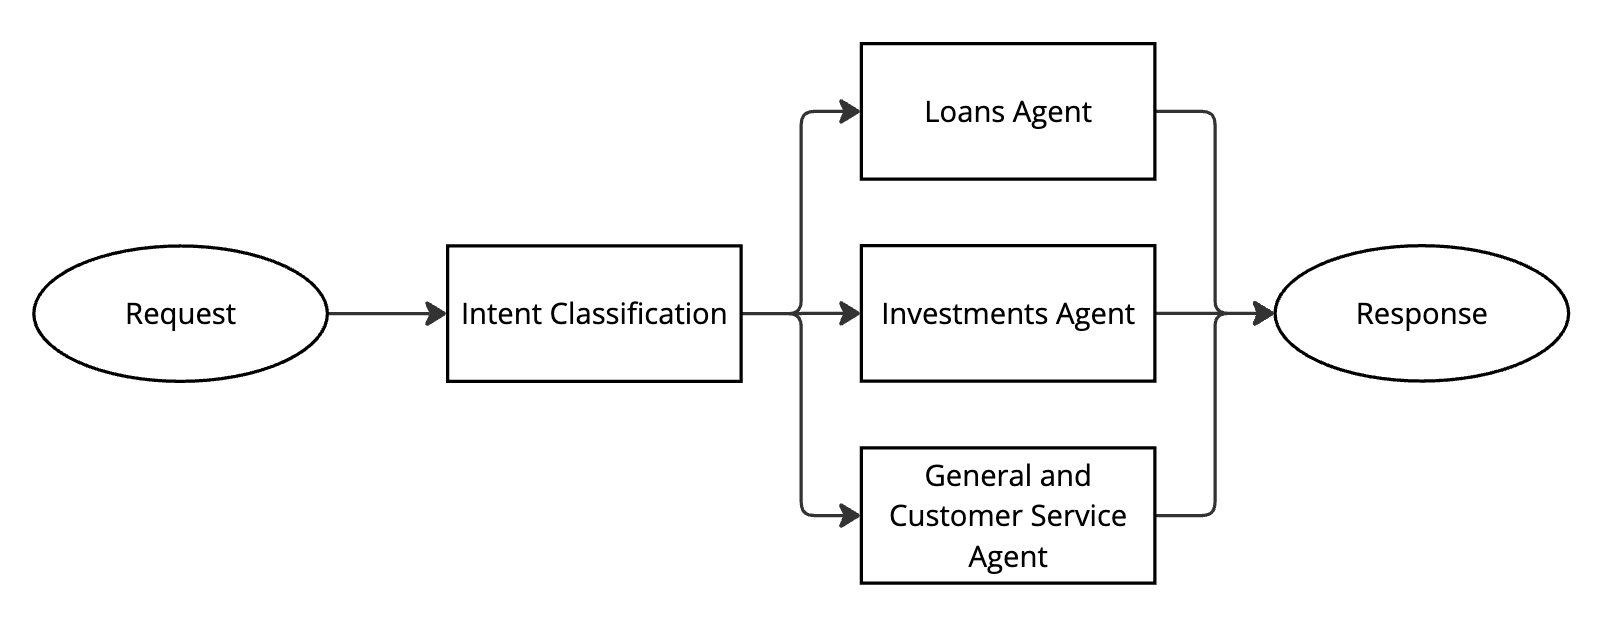

In [ ]:
%%writefile workflow.py

from genai_factory.chains import(
    HistorySaver,
    SessionLoader,
    RefineQuery,
    LoanAgent,
    GeneralAgent,
    Choice,
)

from genai_factory import workflow_server

intent_catagories = ["loans", "investments", "other"]

workflow_graph = [
    SessionLoader(),
    RefineQuery(),
    IntentClassifier(classifier_classes=intent_catagories),
    Choice(),
    [
        GeneralAgent(),
        LoanAgent(),
        InvestmentAgent(),
    ],
    HistorySaver(),
]

workflow_server.add_workflow(
    name="banking_workflow",
    graph=workflow_graph,
    workflow_type="application",
)

### 4.3. Deploy and Test

In [ ]:
!genai-factory run ...